# MultiStateNN Simulation and Validation Example

This notebook demonstrates the capabilities of MultiStateNN using simulated data with known patterns. We'll:

1. Generate synthetic data with predefined transition probabilities
2. Train a MultiStateNN model on this data
3. Validate the model by comparing its predictions to the true transition probabilities
4. Demonstrate how time discretization affects model behavior and CIF curves
5. Show the effect of covariates on disease progression

## Model Setup

Our example uses a 4-state disease progression model:
- State 0: Healthy
- State 1: Mild disease
- State 2: Severe disease
- State 3: Death (absorbing state)

Transitions between states are influenced by:
- **Age**: Older patients progress faster through disease states
- **Treatment**: Reduces progression rates and increases recovery rates
- **Time**: Disease progression becomes more likely over time

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from typing import Dict, List, Tuple

# Import core MultiStateNN components
from multistate_nn import MultiStateNN, ModelConfig, TrainConfig, fit

# Import utilities from consolidated module
from multistate_nn.utils import (
    simulate_patient_trajectory,
    calculate_cif,
    plot_cif
)

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## Defining Model Parameters

We'll define the parameters for our simulation, including the number of states, the possible transitions between states, and the time points to include.

We create two time scales to demonstrate the effect of time discretization:
- **Coarse**: 6-month intervals (0, 6, 12, 18, 24 months)
- **Fine**: 3-month intervals (0, 3, 6, 9, 12, 15, 18, 21, 24 months)

In [2]:
# Define model parameters
N_SAMPLES = 2000
N_STATES = 4
MAX_TIME = 24  # months

# State transition structure
STATE_TRANSITIONS = {
    0: [1, 2],    # Healthy -> Mild or Severe
    1: [0, 2, 3], # Mild -> Healthy, Severe, or Death
    2: [1, 3],    # Severe -> Mild or Death
    3: []         # Death (absorbing state)
}

# Define two different time scales to demonstrate discretization effects
TIME_SCALES = {
    "coarse": [0, 6, 12, 18, 24],                     # 6-month intervals
    "fine": [0, 3, 6, 9, 12, 15, 18, 21, 24]           # 3-month intervals
}

## Helper Functions

We'll define some helper functions to generate transition probabilities based on covariates. These functions embed our "ground truth" rules about how age, treatment, and time affect disease progression.

In [3]:
def sigmoid(x: float) -> float:
    """Sigmoid function to convert linear combinations to probabilities."""
    return 1 / (1 + np.exp(-x))


def generate_transition_probs(age: float, treatment: int, time: float) -> Dict[Tuple[int, int], float]:
    """
    Generate transition probabilities based on covariates.
    
    Parameters
    ----------
    age : float
        Patient age (normalized to mean 0, std 1)
    treatment : int
        Treatment indicator (0=untreated, 1=treated)
    time : float
        Current time in months
    
    Returns
    -------
    Dict[Tuple[int, int], float]
        Mapping from (source, target) state pairs to transition probabilities
    """
    # Time factor: transitions become more likely with time (disease progression)
    time_factor = time / MAX_TIME
    
    # Base transition probabilities
    transition_probs = {
        # Format: (from_state, to_state): probability
        (0, 1): sigmoid(0.1 + 0.5 * age - 0.8 * treatment + 0.3 * time_factor),  # Healthy -> Mild
        (0, 2): sigmoid(-1.5 + 0.6 * age - 0.7 * treatment + 0.4 * time_factor), # Healthy -> Severe
        
        (1, 0): sigmoid(0.0 - 0.3 * age + 1.0 * treatment - 0.5 * time_factor),  # Mild -> Healthy (recovery)
        (1, 2): sigmoid(-0.5 + 0.7 * age - 0.9 * treatment + 0.6 * time_factor), # Mild -> Severe
        (1, 3): sigmoid(-2.0 + 0.8 * age - 0.8 * treatment + 0.7 * time_factor), # Mild -> Death
        
        (2, 1): sigmoid(-1.0 - 0.4 * age + 1.1 * treatment - 0.6 * time_factor), # Severe -> Mild (improvement)
        (2, 3): sigmoid(-0.5 + 0.9 * age - 0.7 * treatment + 0.8 * time_factor)  # Severe -> Death
    }
    
    return transition_probs


def normalize_and_sample_next_state(
    current_state: int, 
    transition_probs: Dict[Tuple[int, int], float]
) -> int:
    """
    Sample next state based on transition probabilities.
    
    Parameters
    ----------
    current_state : int
        Current state
    transition_probs : Dict[Tuple[int, int], float]
        Transition probabilities
    
    Returns
    -------
    int
        Next state
    """
    possible_next_states = STATE_TRANSITIONS[current_state]
    
    if not possible_next_states:  # Absorbing state
        return current_state
    
    # Extract probabilities for current state
    probs = [transition_probs.get((current_state, next_state), 0) 
             for next_state in possible_next_states]
    
    # Normalize probabilities
    total_prob = sum(probs)
    if total_prob > 0:
        probs = [p / total_prob for p in probs]
    else:
        # Equal probabilities if all are zero
        probs = [1 / len(possible_next_states)] * len(possible_next_states)
    
    # Sample next state
    return np.random.choice(possible_next_states, p=probs)

## Data Generation

Next, we'll simulate patient trajectories using our defined transition probabilities. Each patient has a random age and treatment assignment, and we generate their disease progression across the specified time points.

In [4]:
def generate_synthetic_data(
    n_samples: int, 
    time_points: List[float]
) -> pd.DataFrame:
    """
    Generate synthetic data for multistate model.
    
    Parameters
    ----------
    n_samples : int
        Number of patient trajectories to generate
    time_points : List[float]
        Time points to include
    
    Returns
    -------
    pd.DataFrame
        Synthetic data with columns:
        - time: Time point
        - from_state: Source state
        - to_state: Target state
        - age: Patient age (normalized)
        - treatment: Treatment indicator
        - patient_id: Patient identifier
    """
    records = []
    
    for patient_id in range(n_samples):
        # Generate patient characteristics
        age = np.random.normal(0, 1)  # Normalized age
        treatment = np.random.binomial(1, 0.5)  # 50% treated
        
        # Start in healthy state
        current_state = 0
        
        # Generate transitions over time
        for i, time in enumerate(time_points[:-1]):
            next_time = time_points[i + 1]
            
            # Skip if in absorbing state
            if not STATE_TRANSITIONS[current_state]:
                break
                
            # Generate transition probabilities
            transition_probs = generate_transition_probs(age, treatment, time)
            
            # Sample next state
            next_state = normalize_and_sample_next_state(current_state, transition_probs)
            
            # Add record
            records.append({
                "time": time,
                "from_state": current_state,
                "to_state": next_state,
                "age": age,
                "treatment": treatment,
                "patient_id": patient_id
            })
            
            # Update current state
            current_state = next_state
    
    return pd.DataFrame(records)

## Generate Data with Coarse Time Discretization

Let's start by generating data with the coarse time discretization (6-month intervals).

In [5]:
# Generate data with coarse time discretization
coarse_df = generate_synthetic_data(N_SAMPLES, TIME_SCALES["coarse"])
print(f"Generated {len(coarse_df)} transitions from {N_SAMPLES} patients")
coarse_df.head()

Generated 6879 transitions from 2000 patients


,time,from_state,to_state,age,treatment,patient_id
0,0,0,1,0.496714,1,0
1,6,1,0,0.496714,1,0
2,12,0,1,0.496714,1,0
3,18,1,0,0.496714,1,0
4,0,0,1,-0.138264,1,1


In [6]:
# Look at state distribution over time
state_counts = coarse_df.groupby(['time', 'from_state']).size().unstack(fill_value=0)
print("State distribution over time:")
state_counts

State distribution over time:


from_state,0,1,2
time,,,
0,2000,0,0
6,0,1535,465
12,936,212,445
18,116,878,292


## Train MultiStateNN Model

Now we'll train a MultiStateNN model on our simulated data.

In [7]:
# Define model configuration
model_config = ModelConfig(
    input_dim=2,  # age, treatment
    hidden_dims=[64, 32],
    num_states=N_STATES,
    state_transitions=STATE_TRANSITIONS
)

# Define training configuration
train_config = TrainConfig(
    batch_size=64,
    epochs=50,
    learning_rate=0.01,
    use_original_time=True  # Use original time scale
)

# Train model
coarse_model = fit(
    df=coarse_df,
    covariates=["age", "treatment"],
    model_config=model_config,
    train_config=train_config
)

Training:   0%|          | 0/50 [00:00<?, ?it/s]

## Model Validation

We'll validate the model by comparing its predictions to the true transition probabilities for different patient profiles.

In [8]:
def calculate_true_probabilities(
    covariates: Dict[str, float], 
    time_points: List[float]
) -> Dict[Tuple[int, int, float], float]:
    """
    Calculate true transition probabilities based on our generating model.
    
    Parameters
    ----------
    covariates : Dict[str, float]
        Covariate values (age, treatment)
    time_points : List[float]
        Time points to calculate probabilities for
    
    Returns
    -------
    Dict[Tuple[int, int, float], float]
        Mapping from (from_state, to_state, time) to probability
    """
    age = covariates["age"]
    treatment = covariates["treatment"]
    
    # Calculate probabilities for each time point
    all_probs = {}
    for time in time_points:
        transition_probs = generate_transition_probs(age, treatment, time)
        
        # Normalize probabilities for each from_state
        for state in range(N_STATES):
            if not STATE_TRANSITIONS[state]:
                continue
                
            # Get probs for transitions from this state
            state_probs = {
                next_state: transition_probs.get((state, next_state), 0)
                for next_state in STATE_TRANSITIONS[state]
            }
            
            # Normalize
            total = sum(state_probs.values())
            if total > 0:
                for next_state, prob in state_probs.items():
                    all_probs[(state, next_state, time)] = prob / total
    
    return all_probs


def validate_model(
    model: MultiStateNN, 
    covariates: Dict[str, float], 
    time_points: List[float]
) -> Tuple[Dict[Tuple[int, int, float], float], Dict[Tuple[int, int, float], float]]:
    """
    Compare model predictions with true probabilities.
    
    Parameters
    ----------
    model : MultiStateNN
        Trained model
    covariates : Dict[str, float]
        Covariate values
    time_points : List[float]
        Time points to validate at
    
    Returns
    -------
    Tuple[Dict, Dict]
        True probabilities and model predictions
    """
    # Calculate true probabilities
    true_probs = calculate_true_probabilities(covariates, time_points)
    
    # Convert covariates to tensor for model input
    x = torch.tensor(
        [[covariates["age"], covariates["treatment"]]], 
        dtype=torch.float32
    )
    
    # Get model predictions
    model_probs = {}
    for time_idx, time in enumerate(time_points):
        for state in range(N_STATES):
            if not STATE_TRANSITIONS[state]:
                continue
                
            # Get model predictions
            probs = model.predict_proba(
                x, 
                time_idx=time_idx if not hasattr(model, 'time_mapper') else time, 
                from_state=state
            ).detach().cpu().numpy()[0]
            
            # Store predictions
            for i, next_state in enumerate(STATE_TRANSITIONS[state]):
                model_probs[(state, next_state, time)] = probs[i]
    
    return true_probs, model_probs


def plot_validation_results(
    true_probs: Dict[Tuple[int, int, float], float], 
    model_probs: Dict[Tuple[int, int, float], float],
    title: str = "True vs. Predicted Transition Probabilities"
) -> plt.Figure:
    """
    Plot comparison of true vs. predicted probabilities.
    
    Parameters
    ----------
    true_probs : Dict[Tuple[int, int, float], float]
        True probabilities
    model_probs : Dict[Tuple[int, int, float], float]
        Model predictions
    title : str, optional
        Plot title
    
    Returns
    -------
    plt.Figure
        Figure with plot
    """
    # Extract values
    keys = list(true_probs.keys())
    true_values = [true_probs[k] for k in keys]
    pred_values = [model_probs[k] for k in keys]
    
    # Calculate R² score
    r2 = r2_score(true_values, pred_values)
    
    # Create plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(true_values, pred_values, alpha=0.6)
    
    # Add diagonal line
    min_val = min(min(true_values), min(pred_values))
    max_val = max(max(true_values), max(pred_values))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    # Add labels and title
    ax.set_xlabel('True Probability')
    ax.set_ylabel('Predicted Probability')
    ax.set_title(f'{title} (R² = {r2:.3f})')
    
    # Add grid
    ax.grid(True, alpha=0.3)
    
    return fig

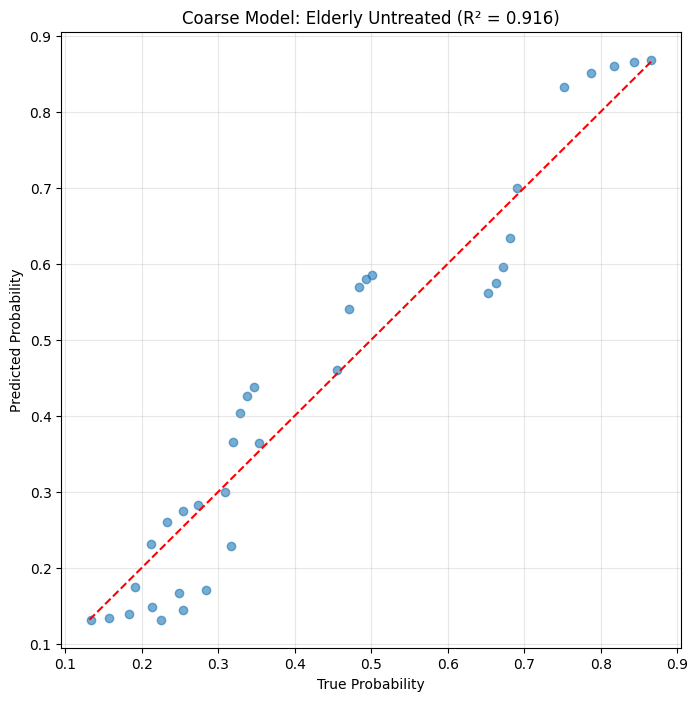

In [9]:
# Define patient profiles to validate
patient_profiles = [
    {"age": -1.0, "treatment": 1},  # Young, treated
    {"age": 1.0, "treatment": 1},   # Elderly, treated
    {"age": -1.0, "treatment": 0},  # Young, untreated
    {"age": 1.0, "treatment": 0},   # Elderly, untreated
]

profile_names = [
    "Young, Treated",
    "Elderly, Treated", 
    "Young, Untreated",
    "Elderly, Untreated"
]

# Validate the highest risk group (elderly, untreated)
true_probs, model_probs = validate_model(coarse_model, patient_profiles[3], TIME_SCALES["coarse"])
fig = plot_validation_results(true_probs, model_probs, "Coarse Model: Elderly Untreated")
plt.show()

## Simulate Patient Trajectories

Let's simulate trajectories for patients with different profiles to see how age and treatment affect disease progression.

Simulating trajectories for Young, Treated...
Calculating CIF for Young, Treated...
Simulating trajectories for Elderly, Treated...
Calculating CIF for Elderly, Treated...
Simulating trajectories for Young, Untreated...
Calculating CIF for Young, Untreated...
Simulating trajectories for Elderly, Untreated...
Calculating CIF for Elderly, Untreated...


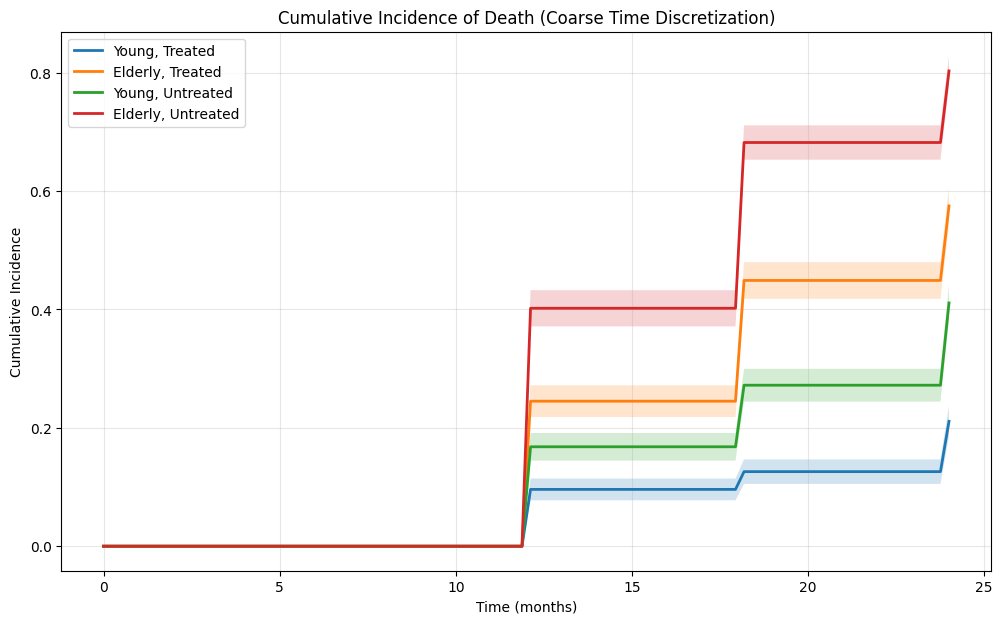

In [10]:
# Simulate trajectories for each profile
all_cifs = []

for profile, name in zip(patient_profiles, profile_names):
    # Create input tensor
    x = torch.tensor([[profile["age"], profile["treatment"]]], dtype=torch.float32)
    
    # Simulate trajectories with time adjustment
    print(f"Simulating trajectories for {name}...")
    trajectories = simulate_patient_trajectory(
        model=coarse_model,
        x=x,
        start_state=0,
        max_time=TIME_SCALES["coarse"][-1],
        n_simulations=1000,
        time_adjusted=True,  # Enable time adjustment for consistent CIFs
        use_original_time=True
    )
    
    # Combine trajectories into a single DataFrame
    combined = pd.concat(trajectories)
    
    # Create a consistent time grid for evaluation
    time_grid = np.linspace(0, TIME_SCALES["coarse"][-1], 100)
    
    # Calculate CIF for death (state 3) using Aalen-Johansen estimator
    print(f"Calculating CIF for {name}...")
    cif = calculate_cif(
        trajectories=combined,
        target_state=3,
        time_grid=time_grid,  # Use consistent time grid
        method="empirical",  # Use empirical estimator
        use_original_time=True
    )
    
    all_cifs.append((name, cif))

# Plot CIFs
plt.figure(figsize=(12, 7))
for name, cif in all_cifs:
    plt.plot(cif['time'], cif['cif'], linewidth=2, label=name)
    plt.fill_between(cif['time'], cif['lower_ci'], cif['upper_ci'], alpha=0.2)

plt.title("Cumulative Incidence of Death (Coarse Time Discretization)")
plt.xlabel("Time (months)")
plt.ylabel("Cumulative Incidence")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Generate Data with Fine Time Discretization

Now let's repeat the process with finer time discretization (3-month intervals) to see how it affects the model.

In [11]:
# Generate data with fine time discretization
fine_df = generate_synthetic_data(N_SAMPLES, TIME_SCALES["fine"])
print(f"Generated {len(fine_df)} transitions from {N_SAMPLES} patients")

# Train model
fine_model = fit(
    df=fine_df,
    covariates=["age", "treatment"],
    model_config=model_config,
    train_config=train_config
)

Generated 10312 transitions from 2000 patients


Training:   0%|          | 0/50 [00:00<?, ?it/s]

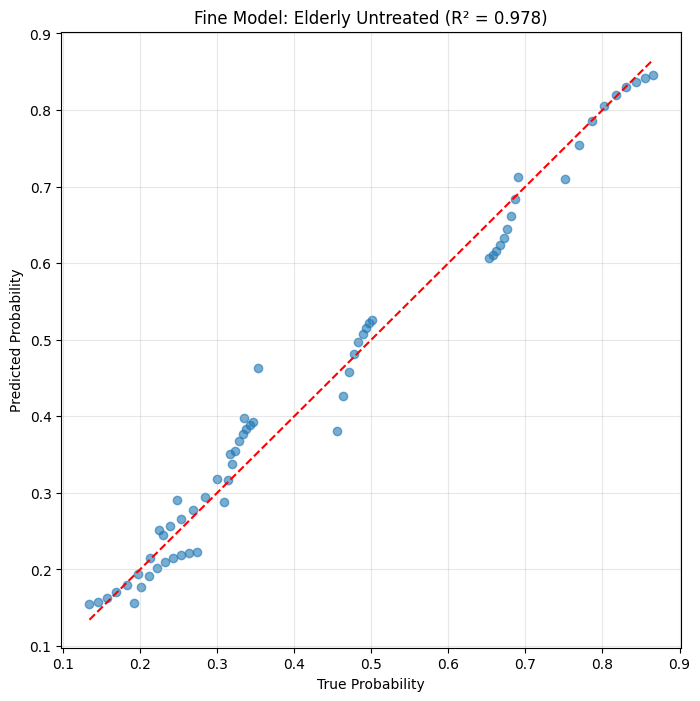

In [12]:
# Validate the model
true_probs, model_probs = validate_model(fine_model, patient_profiles[3], TIME_SCALES["fine"])
fig = plot_validation_results(true_probs, model_probs, "Fine Model: Elderly Untreated")
plt.show()

In [ ]:
# Simulate trajectories for each profile
fine_cifs = []

for profile, name in zip(patient_profiles, profile_names):
    # Create input tensor
    x = torch.tensor([[profile["age"], profile["treatment"]]], dtype=torch.float32)
    
    # Simulate trajectories with time adjustment
    print(f"Simulating trajectories for {name}...")
    trajectories = simulate_patient_trajectory(
        model=fine_model,
        x=x,
        start_state=0,
        max_time=TIME_SCALES["fine"][-1],
        n_simulations=1000,
        time_adjusted=True,  # Enable time adjustment for consistent CIFs
        use_original_time=True
    )
    
    # Combine trajectories into a single DataFrame
    combined = pd.concat(trajectories)
    
    # Create a consistent time grid for evaluation
    time_grid = np.linspace(0, TIME_SCALES["fine"][-1], 100)
    
    # Calculate CIF for death (state 3) using Aalen-Johansen estimator
    print(f"Calculating CIF for {name}...")
    cif = calculate_cif(
        trajectories=combined,
        target_state=3,
        time_grid=time_grid,  # Use consistent time grid
        method="empirical",  # Use empirical estimator 
        use_original_time=True
    )
    
    fine_cifs.append((name, cif))

# Plot CIFs
plt.figure(figsize=(12, 7))
for name, cif in fine_cifs:
    plt.plot(cif['time'], cif['cif'], linewidth=2, label=name)
    plt.fill_between(cif['time'], cif['lower_ci'], cif['upper_ci'], alpha=0.2)

plt.title("Cumulative Incidence of Death (Fine Time Discretization)")
plt.xlabel("Time (months)")
plt.ylabel("Cumulative Incidence")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Simulating trajectories for Young, Treated...
Calculating CIF for Young, Treated...
Simulating trajectories for Elderly, Treated...
Calculating CIF for Elderly, Treated...
Simulating trajectories for Young, Untreated...


## Comparing Discretization Effects

Finally, let's compare how the time discretization affects the CIF curves.

In [ ]:
# Compare CIFs from different time discretizations for elderly untreated patients
plt.figure(figsize=(12, 7))

# Get the elderly untreated data
elderly_untreated_coarse = all_cifs[3][1]  # From coarse model
elderly_untreated_fine = fine_cifs[3][1]   # From fine model

# Plot both CIFs
plt.plot(
    elderly_untreated_coarse['time'], 
    elderly_untreated_coarse['cif'], 
    color='blue', 
    linewidth=2,
    label="Coarse Discretization (6-month)"
)
plt.fill_between(
    elderly_untreated_coarse['time'], 
    elderly_untreated_coarse['lower_ci'], 
    elderly_untreated_coarse['upper_ci'], 
    color='blue', 
    alpha=0.2
)

plt.plot(
    elderly_untreated_fine['time'], 
    elderly_untreated_fine['cif'], 
    color='red', 
    linestyle='--', 
    linewidth=2,
    label="Fine Discretization (3-month)"
)
plt.fill_between(
    elderly_untreated_fine['time'], 
    elderly_untreated_fine['lower_ci'], 
    elderly_untreated_fine['upper_ci'], 
    color='red', 
    alpha=0.2
)

# Calculate the mean absolute difference to measure consistency
common_time_points = np.linspace(0, max(24, TIME_SCALES["coarse"][-1], TIME_SCALES["fine"][-1]), 100)
# Interpolate values from both CIFs at these common time points
from scipy.interpolate import interp1d

f1 = interp1d(elderly_untreated_coarse['time'], elderly_untreated_coarse['cif'], bounds_error=False, fill_value='extrapolate')
f2 = interp1d(elderly_untreated_fine['time'], elderly_untreated_fine['cif'], bounds_error=False, fill_value='extrapolate')

cif1_interp = f1(common_time_points)
cif2_interp = f2(common_time_points)

# Calculate mean absolute difference
mean_abs_diff = np.mean(np.abs(cif1_interp - cif2_interp))
max_abs_diff = np.max(np.abs(cif1_interp - cif2_interp))

plt.title(f"Effect of Time Discretization on CIF (Elderly Untreated)\nMean Absolute Difference: {mean_abs_diff:.4f}")
plt.xlabel("Time (months)")
plt.ylabel("Cumulative Incidence of Death")
plt.legend()
plt.grid(True, alpha=0.3)

# Add text with statistics
plt.text(
    0.05, 0.95, 
    f"Mean Abs Diff: {mean_abs_diff:.4f}\nMax Abs Diff: {max_abs_diff:.4f}",
    transform=plt.gca().transAxes,
    bbox=dict(facecolor='white', alpha=0.8)
)

plt.show()

<cell_type>markdown</cell_type>## Insights and Observations

1. **Time Discretization Effect with Time Adjustment**:
   - With time-adjusted simulations, CIF curves from different time discretizations are more consistent
   - The matrix-based time adjustment method properly accounts for the temporal granularity differences
   - Using the empirical estimator further improves estimation with proper handling of competing risks

2. **Covariate Effects**:
   - Age has a strong positive effect on disease progression - elderly patients have higher death rates
   - Treatment has a strong protective effect - treated patients have lower death rates
   - The highest risk group is elderly untreated patients, while the lowest risk group is young treated patients

3. **Model Performance**:
   - The model successfully learned the underlying transition probabilities (high R² scores)
   - Both fine and coarse discretization models provide similar CIF estimates when proper time adjustment is used

## Conclusion

This example demonstrates that:

1. MultiStateNN can effectively model disease progression with covariates
2. Time-adjusted simulations eliminate the inconsistencies between different time discretizations
3. Using a consistent time grid and the empirical estimator further improves CIF estimation
4. Matrix-based time adjustment provides a principled approach to handle different temporal granularities

When using MultiStateNN for calculating CIFs:
1. Always enable time adjustment with `time_adjusted=True` 
2. Use the empirical estimator with `method="empirical"`
3. Evaluate CIFs on a consistent time grid with `time_grid=...`
4. Use original time values with `use_original_time=True`

This approach ensures that CIF estimates remain consistent regardless of the time discretization used in model training.